In [13]:
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib as mpl
import matplotlib.cm as cm
import cartopy.crs as ccrs

sys.path.append(os.path.abspath('../kernel_inference'))
import pathfinder as pf
from mapbox import get_plot, add_rect
from kernel_inference import Bins, Rect, uniq

%matplotlib inline

### Import and filter data

In [14]:
%%time 
INPUT_FILE = '../data/trip_data_1_full.csv'
DATETIME_FORMAT = '%Y-%m-%d %H:%M:%S'
TRIP_TIME_CUTOFF = 1500 # Max trip time in seconds
NFRAMES = 24  # Number of time slices to split a day into

manhattan_rect = Rect(-74.025, -73.92, 40.70, 40.85)
bins = Bins(manhattan_rect, 0.0025)
rect = bins.get_rect(9, 12) # Our origin rectangle

# Computes time intervals for grouping by time
starts = [dt.time(x / 60, x % 60) for x in range(0, 1440, 1440 / NFRAMES)]
ends = starts[1:] + [starts[0]]

def process_df(df):
    df = df[(df['pickup_longitude'] >= rect.xmin) &
            (df['pickup_longitude'] <= rect.xmax) &
            (df['pickup_latitude']  >= rect.ymin) &
            (df['pickup_latitude']  <= rect.ymax)]

    df = df[df['trip_time_in_secs'] < TRIP_TIME_CUTOFF]
    # Convert to datetime objects
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df = df.set_index(pd.DatetimeIndex(df['pickup_datetime']))
    return df

data_chunks = pd.read_csv(INPUT_FILE, iterator=True, chunksize=10000)
td = pd.concat(process_df(df) for df in data_chunks)
trips = [td.between_time(s, e) for s, e in zip(starts, ends)]
print 'Number of trips: {}'.format(len(td))

Number of trips: 50423
CPU times: user 3min 17s, sys: 913 ms, total: 3min 18s
Wall time: 3min 18s


### Import pathfinder

In [15]:
graph = pf.make_graph('central_ny')
ip = pf.Interpolator(graph)
pif = pf.PIFPathfinder(graph)

In [16]:
bins.clear_bins()
data = pd.concat(trips[14:20])
print len(data)
for _, row in data.iterrows():
    locs = [[row['pickup_latitude'], row['pickup_longitude']],
            [row['dropoff_latitude'], row['dropoff_longitude']]]
    path = pif.pathfind(locs)
    if path == []: continue
    interpolated = [bins.get_bin(x, y) for x, y in ip.interpolate(path, 10)]
    time = np.linspace(0, row['trip_time_in_secs'], len(interpolated))
    for (x, y), t in uniq(zip(interpolated, time), lambda x: x[0]):
        bins.bins[(x, y)].append(t)

11007


In [17]:
def plot(fn, maxtime):
    fig, ax = get_plot(manhattan_rect, figsize=(9, 15))
    for (nx, ny), times in bins.bins.items():
        add_rect(ax, bins.get_rect(nx, ny), lw=0,
                 alpha=0.2 + min(len(times)/250.0, 0.8),
                 facecolor=cm.RdYlGn_r(int(fn(times) * 255 / maxtime)))
    sc = plt.scatter([0], [0], c=[0],cmap=cm.RdYlGn_r, vmin=0, vmax=maxtime)
    plt.colorbar(sc).set_label('Seconds')
    return fig, ax

Mean


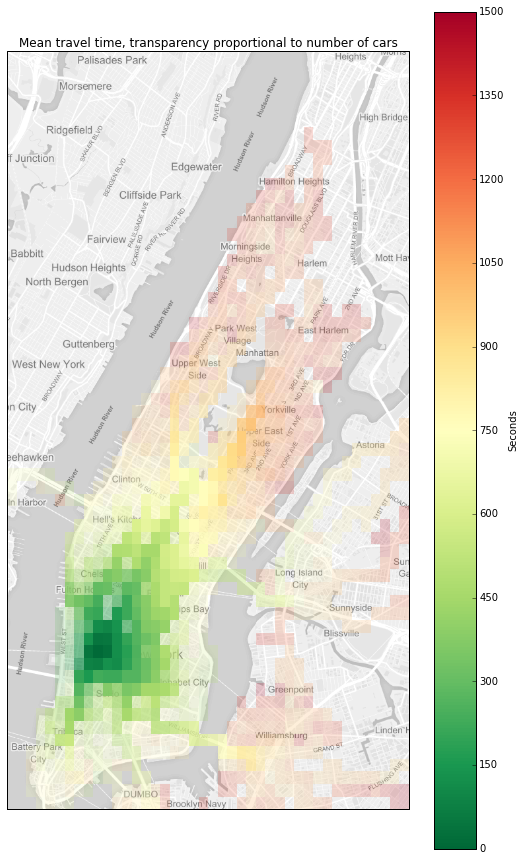

In [18]:
print "Mean"
fig, ax = plot(np.mean, TRIP_TIME_CUTOFF)
plt.title('Mean travel time, transparency proportional to number of cars')

75th percentile


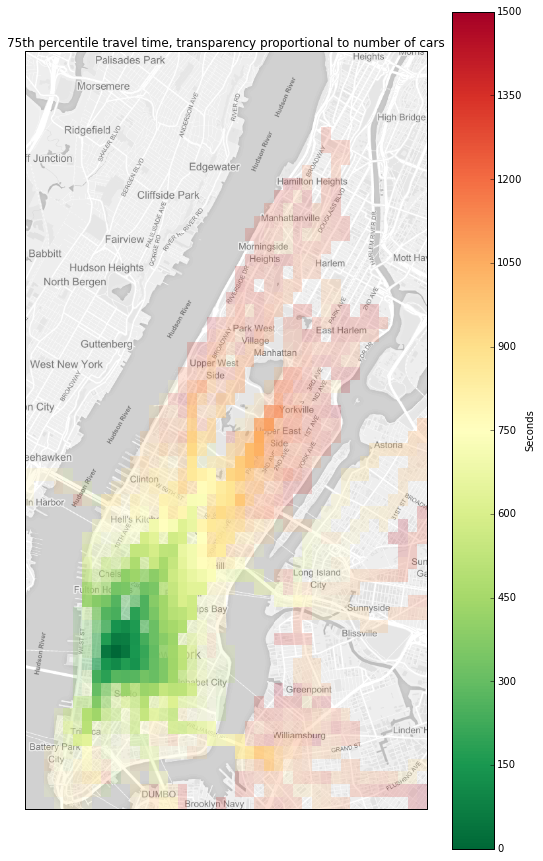

In [19]:
print "75th percentile"
fig, ax = plot(lambda x: np.percentile(x, 75), TRIP_TIME_CUTOFF)
plt.title('75th percentile travel time, transparency proportional to number of cars')

25th percentile


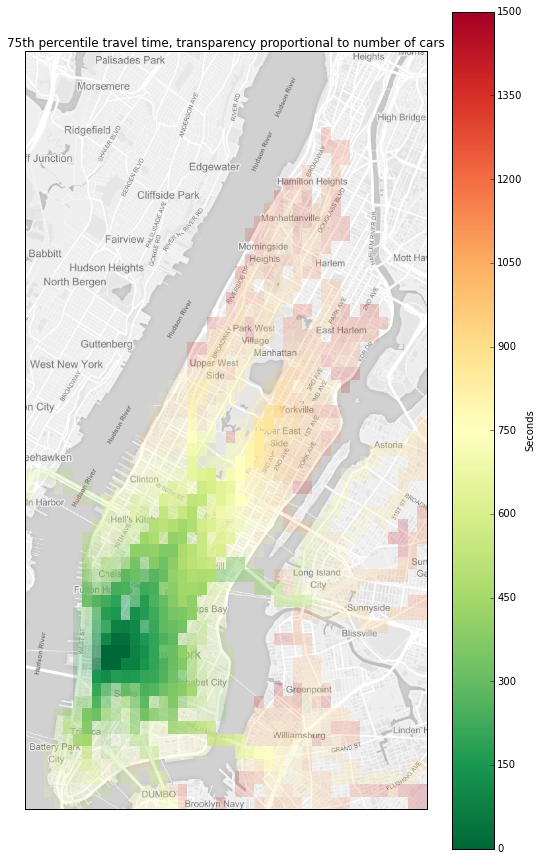

In [20]:
print "25th percentile"
fig, ax = plot(lambda x: np.percentile(x, 25), TRIP_TIME_CUTOFF)
plt.title('75th percentile travel time, transparency proportional to number of cars')

SD


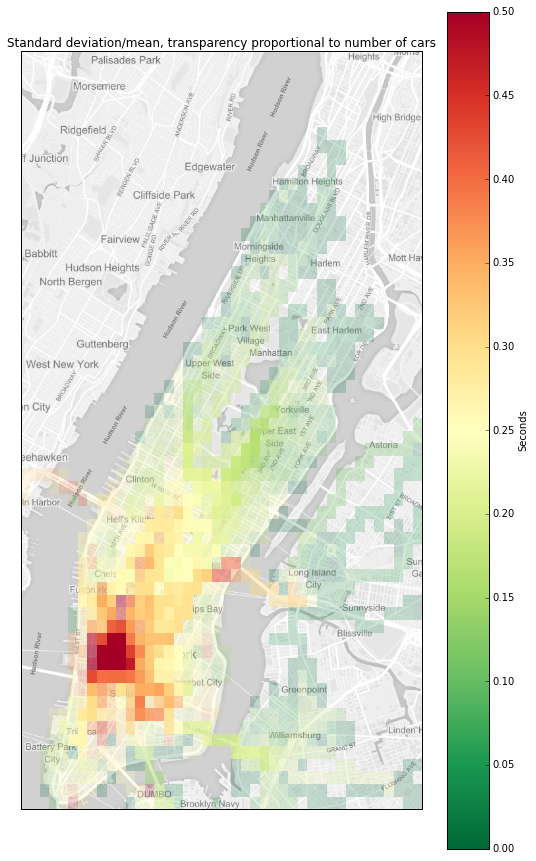

In [24]:
print "SD"
fig, ax = plot(lambda x:np.std(x)/np.mean(x), 0.5)
plt.title('Standard deviation/mean, transparency proportional to number of cars')
